In [1]:
import pandas as pd
import numpy as np
import rioxarray
import json, os

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier

from imblearn.over_sampling import RandomOverSampler, SMOTE

In [2]:
seed = 42
verbose = False
details = False

In [3]:
INVASIVE_BIRDS_PATH = 'Datasets/Machine Learning/10km Rasters/Birds'
# Use this if using coordinates as separate columns
# df_10km = pd.read_csv('Datasets/Machine Learning/Dataframes/10km_All_Birds_DF.csv')

# Use this if using coordinates as indices
df_10km = pd.read_csv('Datasets/Machine Learning/Dataframes/10km_All_Birds_DF.csv', index_col=[0,1])

total_birds = (df_10km['Occurrence']==1).sum()
df_dicts = []

for file in os.listdir(INVASIVE_BIRDS_PATH):
    filename = os.fsdecode(file)
    if not filename.endswith('.tif') or filename.endswith('All_Invasive_Birds_10km.tif') :
         continue



    bird_name = filename[:-4].replace('_', ' ')

    bird_dataset = rioxarray.open_rasterio(f'{INVASIVE_BIRDS_PATH}/{file}')
    bird_dataset.name = 'data'
    bird_df = bird_dataset.squeeze().drop("spatial_ref").drop("band").to_dataframe()

    # Check if index matches
    if not df_10km.index.equals(bird_df.index):
        print('Warning: Index does not match')
        continue

    bird_df['Occurrence'] = [0 if x == -1 else 1 for x in bird_df['data']]
    bird_df = df_10km.drop(columns='Occurrence').join(bird_df.drop(columns='data'))
    
    bird_dict = {'name' : bird_name, 'dataframe' : bird_df }
    df_dicts.append(bird_dict)
    display(bird_df.sample(5))


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_10km,Mancozeb_10km,Mecoprop-P_10km,Metamitron_10km,Pendimethalin_10km,PropamocarbHydrochloride_10km,Prosulfocarb_10km,Sulphur_10km,Tri-allate_10km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
5000.0,185000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
155000.0,595000.0,17,0,44,18,0,21,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
345000.0,515000.0,2,0,94,3,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
615000.0,345000.0,11,1,1,70,0,0,16,0,0,0,...,2.397917e+01,4.867601e+00,6.460490e+00,8.218880e+00,1.587924e+01,4.202494e+00,3.598979e-01,4.151691e-01,1.232334e-04,0
1265000.0,295000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_10km,Mancozeb_10km,Mecoprop-P_10km,Metamitron_10km,Pendimethalin_10km,PropamocarbHydrochloride_10km,Prosulfocarb_10km,Sulphur_10km,Tri-allate_10km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
115000.0,565000.0,6,0,8,75,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,1
965000.0,225000.0,0,0,0,0,0,0,0,0,0,100,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
135000.0,335000.0,0,0,36,18,14,0,0,8,0,0,...,1.994784e+01,2.263919e+00,3.575538e+00,1.609499e+01,1.175125e+01,8.727835e+00,1.639951e+01,3.861626e+00,6.875669e-01,1
1235000.0,315000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1275000.0,605000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_10km,Mancozeb_10km,Mecoprop-P_10km,Metamitron_10km,Pendimethalin_10km,PropamocarbHydrochloride_10km,Prosulfocarb_10km,Sulphur_10km,Tri-allate_10km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
575000.0,545000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
855000.0,655000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1195000.0,45000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
295000.0,525000.0,0,0,97,2,0,0,0,0,0,0,...,2.816632e+01,1.967386e+01,4.224688e+00,8.083311e+00,2.176484e+01,4.580381e+00,9.110498e+00,5.536621e+00,5.320936e+00,0
395000.0,595000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_10km,Mancozeb_10km,Mecoprop-P_10km,Metamitron_10km,Pendimethalin_10km,PropamocarbHydrochloride_10km,Prosulfocarb_10km,Sulphur_10km,Tri-allate_10km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
675000.0,305000.0,3,0,81,15,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,1
1165000.0,265000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1225000.0,95000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
995000.0,75000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
645000.0,75000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_10km,Mancozeb_10km,Mecoprop-P_10km,Metamitron_10km,Pendimethalin_10km,PropamocarbHydrochloride_10km,Prosulfocarb_10km,Sulphur_10km,Tri-allate_10km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
285000.0,645000.0,19,0,48,30,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
855000.0,185000.0,16,0,0,15,0,0,0,0,0,49,...,1.514845e-02,3.407478e-03,1.233685e-02,-3.400000e+38,6.557040e-03,-3.400000e+38,-3.400000e+38,-3.400000e+38,1.351355e+00,0
1085000.0,265000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1195000.0,315000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
105000.0,685000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_10km,Mancozeb_10km,Mecoprop-P_10km,Metamitron_10km,Pendimethalin_10km,PropamocarbHydrochloride_10km,Prosulfocarb_10km,Sulphur_10km,Tri-allate_10km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
515000.0,575000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
645000.0,35000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
945000.0,95000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
775000.0,315000.0,0,0,0,0,0,2,1,0,8,0,...,5.956215e+00,4.986659e+00,6.333358e+00,-3.400000e+38,3.149487e+00,3.018634e+00,4.687809e-01,5.034044e+00,7.943451e+00,0
95000.0,95000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_10km,Mancozeb_10km,Mecoprop-P_10km,Metamitron_10km,Pendimethalin_10km,PropamocarbHydrochloride_10km,Prosulfocarb_10km,Sulphur_10km,Tri-allate_10km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
945000.0,475000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1175000.0,245000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
175000.0,385000.0,15,0,57,23,0,0,0,0,0,0,...,4.448481e+01,9.537368e-01,6.209843e+00,1.240064e+01,1.836793e+01,7.359963e+00,2.734950e+01,1.543392e+01,9.452468e+00,0
735000.0,465000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
915000.0,85000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_10km,Mancozeb_10km,Mecoprop-P_10km,Metamitron_10km,Pendimethalin_10km,PropamocarbHydrochloride_10km,Prosulfocarb_10km,Sulphur_10km,Tri-allate_10km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
55000.0,415000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1125000.0,335000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
525000.0,25000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
545000.0,305000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1055000.0,375000.0,0,0,0,33,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_10km,Mancozeb_10km,Mecoprop-P_10km,Metamitron_10km,Pendimethalin_10km,PropamocarbHydrochloride_10km,Prosulfocarb_10km,Sulphur_10km,Tri-allate_10km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1225000.0,575000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
295000.0,655000.0,0,0,0,9,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,1
215000.0,215000.0,4,0,0,85,0,0,0,0,0,0,...,2.098964e-02,4.535805e-03,2.770425e-02,-3.400000e+38,1.327652e-02,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
575000.0,455000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
625000.0,515000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_10km,Mancozeb_10km,Mecoprop-P_10km,Metamitron_10km,Pendimethalin_10km,PropamocarbHydrochloride_10km,Prosulfocarb_10km,Sulphur_10km,Tri-allate_10km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
325000.0,155000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,2.247949e-01,0
435000.0,195000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
775000.0,445000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
535000.0,495000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1295000.0,215000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_10km,Mancozeb_10km,Mecoprop-P_10km,Metamitron_10km,Pendimethalin_10km,PropamocarbHydrochloride_10km,Prosulfocarb_10km,Sulphur_10km,Tri-allate_10km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
865000.0,205000.0,0,0,0,0,0,0,0,0,0,7,...,8.027495e+00,8.000409e-01,5.404873e+00,5.992115e+00,2.905461e+00,3.234832e+00,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
545000.0,5000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
725000.0,615000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
735000.0,685000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
415000.0,675000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_10km,Mancozeb_10km,Mecoprop-P_10km,Metamitron_10km,Pendimethalin_10km,PropamocarbHydrochloride_10km,Prosulfocarb_10km,Sulphur_10km,Tri-allate_10km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
845000.0,345000.0,2,13,5,80,0,0,0,0,0,0,...,4.912306e+00,1.034424e+01,3.395481e+00,-3.400000e+38,5.040710e+00,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,1
1265000.0,625000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
25000.0,335000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
395000.0,65000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
805000.0,625000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_10km,Mancozeb_10km,Mecoprop-P_10km,Metamitron_10km,Pendimethalin_10km,PropamocarbHydrochloride_10km,Prosulfocarb_10km,Sulphur_10km,Tri-allate_10km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1225000.0,525000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
735000.0,545000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
715000.0,545000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
475000.0,75000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
955000.0,155000.0,0,0,0,0,0,0,0,0,5,1,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_10km,Mancozeb_10km,Mecoprop-P_10km,Metamitron_10km,Pendimethalin_10km,PropamocarbHydrochloride_10km,Prosulfocarb_10km,Sulphur_10km,Tri-allate_10km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
665000.0,345000.0,22,0,52,26,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
875000.0,635000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
885000.0,375000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
515000.0,605000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
985000.0,425000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_10km,Mancozeb_10km,Mecoprop-P_10km,Metamitron_10km,Pendimethalin_10km,PropamocarbHydrochloride_10km,Prosulfocarb_10km,Sulphur_10km,Tri-allate_10km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1095000.0,185000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
985000.0,345000.0,0,0,0,98,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1085000.0,365000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
325000.0,645000.0,2,0,19,67,0,0,0,1,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,1
195000.0,125000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,4.487841e-02,3.156656e-02,2.022360e+00,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_10km,Mancozeb_10km,Mecoprop-P_10km,Metamitron_10km,Pendimethalin_10km,PropamocarbHydrochloride_10km,Prosulfocarb_10km,Sulphur_10km,Tri-allate_10km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1205000.0,35000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
615000.0,85000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
295000.0,645000.0,8,0,74,10,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1095000.0,675000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1125000.0,375000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_10km,Mancozeb_10km,Mecoprop-P_10km,Metamitron_10km,Pendimethalin_10km,PropamocarbHydrochloride_10km,Prosulfocarb_10km,Sulphur_10km,Tri-allate_10km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
685000.0,165000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,1
705000.0,325000.0,6,20,0,72,0,0,2,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,1
325000.0,685000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
465000.0,55000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
865000.0,175000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_10km,Mancozeb_10km,Mecoprop-P_10km,Metamitron_10km,Pendimethalin_10km,PropamocarbHydrochloride_10km,Prosulfocarb_10km,Sulphur_10km,Tri-allate_10km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
845000.0,685000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
545000.0,425000.0,5,0,72,18,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
15000.0,645000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
975000.0,475000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
135000.0,605000.0,0,0,87,11,0,0,0,2,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_10km,Mancozeb_10km,Mecoprop-P_10km,Metamitron_10km,Pendimethalin_10km,PropamocarbHydrochloride_10km,Prosulfocarb_10km,Sulphur_10km,Tri-allate_10km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
875000.0,625000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
15000.0,635000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
845000.0,125000.0,0,0,0,11,0,0,0,0,0,88,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1055000.0,195000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
525000.0,565000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_10km,Mancozeb_10km,Mecoprop-P_10km,Metamitron_10km,Pendimethalin_10km,PropamocarbHydrochloride_10km,Prosulfocarb_10km,Sulphur_10km,Tri-allate_10km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
75000.0,375000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,1.790037e-01,-3.400000e+38,9.841958e-02,1.722172e+01,3.735671e+00,2.387910e+01,1
15000.0,155000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
985000.0,15000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
335000.0,585000.0,3,2,86,9,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
75000.0,655000.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


In [4]:
# Drop Fertiliser and Pesticide
for dict in df_dicts:
    cur_df = dict["dataframe"]
    dict["dataframe"].drop(cur_df.iloc[:, 26:-1], inplace=True, axis=1)
    display(cur_df.sample(5))

,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
515000.0,605000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
1075000.0,55000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
665000.0,295000.0,14,0,0,37,0,0,0,0,0,0,...,0,0,0,49,1751,4,2,8,2,0
1285000.0,325000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
445000.0,305000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
605000.0,65000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
1205000.0,455000.0,0,0,0,0,0,0,0,0,3,0,...,0,0,0,0,-1000,-9999,0,-2,0,0
145000.0,55000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
275000.0,435000.0,0,0,5,41,0,0,0,0,0,0,...,0,0,49,5,863,1,2,4,0,1
195000.0,425000.0,21,0,54,24,0,0,0,0,0,0,...,0,0,0,1,1016,3,2,9,3,1


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1015000.0,385000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
175000.0,95000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
345000.0,595000.0,0,0,0,0,0,0,0,0,0,0,...,6,94,0,0,-1000,-9999,0,-2,0,1
1275000.0,605000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
575000.0,645000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
475000.0,255000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
295000.0,355000.0,28,2,0,70,0,0,0,0,0,0,...,0,0,0,1,1661,3,2,8,2,0
915000.0,185000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
65000.0,455000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-1000,-9999,0,-2,0,0
845000.0,75000.0,0,0,0,100,0,0,0,0,0,0,...,0,0,0,0,50,1,2,1,0,1


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1215000.0,85000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
755000.0,435000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
25000.0,495000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
1025000.0,555000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
1175000.0,315000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
735000.0,305000.0,1,0,84,14,0,0,0,0,0,0,...,0,0,0,1,965,9,2,7,144,1
505000.0,185000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
915000.0,685000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
295000.0,225000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
1035000.0,515000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1095000.0,515000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
715000.0,345000.0,4,0,94,1,0,0,0,0,0,0,...,0,0,0,2,1129,1,2,8,0,0
1195000.0,165000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
985000.0,535000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
15000.0,535000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1135000.0,555000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
375000.0,315000.0,1,0,3,94,0,0,0,0,0,0,...,0,0,0,2,1953,5,2,2,96,0
725000.0,5000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
645000.0,635000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
535000.0,55000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1245000.0,605000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
255000.0,225000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-1000,-9999,0,-2,0,0
775000.0,305000.0,0,0,0,0,0,0,0,0,100,0,...,0,0,0,0,7928,5,2,3,8,0
955000.0,295000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2036,9,2,4,16,0
1185000.0,95000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0


Deciduous woodland  Coniferous woodland  Arable  \
y         x                                                           
895000.0  645000.0                   0                    0       0   
395000.0  105000.0                   0                    0       0   
          285000.0                   0                    0       0   
595000.0  275000.0                   0                    2       0   
1025000.0 125000.0                   0                    0       0   

                    Improve grassland  Neutral grassland  \
y         x                                                
895000.0  645000.0                  0                  0   
395000.0  105000.0                  0                  0   
          285000.0                  0                  0   
595000.0  275000.0                  0                  0   
1025000.0 125000.0                  0                  0   

                    Calcareous grassland  Acid grassland  Fen  Heather  \
y         x                                                              
895000.0  645000.0                     0               0    0        0   
395000.0  105000.0                     0               0    0        0   
          285000.0                     0               0    0        0   
595000.0  275000.0                     0              97    0        0   
1025000.0 125000.0                     0               0    0        0   

                    Heather grassland  ...  Littoral sediment  Saltmarsh  \
y         x                            ...                                 
895000.0  645000.0                  0  ...                  0          0   
395000.0  105000.0                  0  ...                  0          0   
          285000.0                  0  ...                  0          0   
595000.0  275000.0                  0  ...                  0          0   
1025000.0 125000.0                  0  ...                  0          0   

                    Urban  Suburban  Elevation  Cumulative catchment area  \
y         x                                                                 
895000.0  645000.0      0         0      -9999                      -9999   
395000.0  105000.0      0         0      -9999                      -9999   
          285000.0      0         0      -9999                      -9999   
595000.0  275000.0      0         0       2657                          1   
1025000.0 125000.0      0         0      -9999                      -9999   

                    Surface type  Outflowing drainage direction  \
y         x                                                       
895000.0  645000.0            -1                             -1   
395000.0  105000.0            -1                             -1   
          285000.0            -1                             -1   
595000.0  275000.0             2                              2   
1025000.0 125000.0            -1                             -1   

                    Inflowing drainage direction  Occurrence  
y         x                                                   
895000.0  645000.0                           255           0  
395000.0  105000.0                           255           0  
          285000.0                           255           0  
595000.0  275000.0                             0           0  
1025000.0 125000.0                           255           0  

[5 rows x 27 columns]

,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
515000.0,465000.0,3,3,2,31,0,0,0,0,0,59,...,0,0,0,3,1484,585,4,38,7,1
205000.0,445000.0,6,0,37,39,0,0,0,0,0,0,...,0,0,0,17,715,6,2,8,4,1
865000.0,375000.0,5,0,32,7,0,0,0,0,0,0,...,0,0,0,0,-1000,-9999,0,-2,0,0
955000.0,105000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
345000.0,555000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-1000,-9999,0,-2,0,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1055000.0,495000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
665000.0,545000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
515000.0,575000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
745000.0,135000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-1000,-9999,0,-2,0,0
445000.0,45000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
605000.0,485000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
955000.0,675000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
245000.0,605000.0,19,0,73,7,0,0,0,0,0,0,...,0,0,0,2,652,2,2,7,16,0
795000.0,25000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
375000.0,135000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
135000.0,405000.0,36,31,33,0,0,0,0,0,0,0,...,0,0,0,0,1554,1,2,7,0,1
1055000.0,415000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
35000.0,475000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
45000.0,5000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
1285000.0,595000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
245000.0,315000.0,0,0,0,0,0,0,100,0,0,0,...,0,0,0,0,3186,4,2,7,4,0
285000.0,675000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
165000.0,265000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
1065000.0,595000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
845000.0,115000.0,0,0,0,16,0,0,0,0,0,0,...,0,0,0,0,-1000,-9999,0,-2,0,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1065000.0,495000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
535000.0,345000.0,10,0,31,59,0,0,0,0,0,0,...,0,0,0,0,1953,5,2,6,8,0
955000.0,485000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
395000.0,595000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
695000.0,445000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1085000.0,635000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
685000.0,195000.0,0,99,0,0,0,0,0,0,0,1,...,0,0,0,0,1871,149,2,2,88,0
505000.0,435000.0,0,0,66,32,0,0,0,0,0,0,...,0,0,0,1,568,3,2,9,3,1
625000.0,275000.0,0,100,0,0,0,0,0,0,0,0,...,0,0,0,0,4436,2,2,2,32,0
315000.0,265000.0,14,0,0,19,28,0,12,0,0,17,...,0,0,0,0,1621,2,2,4,128,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
295000.0,45000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
1155000.0,185000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
255000.0,205000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
1175000.0,605000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
1275000.0,195000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
335000.0,25000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
1135000.0,205000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
545000.0,195000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
245000.0,215000.0,2,0,28,69,0,0,0,0,0,0,...,0,0,0,1,1606,1,2,2,0,0
345000.0,515000.0,2,0,94,3,0,0,0,0,0,0,...,0,0,0,1,85,3,2,8,3,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
235000.0,255000.0,59,25,0,16,0,0,0,0,0,0,...,0,0,0,0,2962,2,2,6,32,0
465000.0,115000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
895000.0,175000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-1000,-9999,0,-2,0,0
35000.0,165000.0,9,0,2,74,0,0,0,0,6,0,...,0,0,0,1,1643,1,2,4,0,0
1115000.0,235000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0


In [5]:
# Data Cleaning
np.random.seed(seed=seed)

for dict in df_dicts:
    cur_df = dict["dataframe"]
    cur_df_name = dict["name"]

    print(f'{cur_df_name} data before drop: \n {cur_df.value_counts("Occurrence")} \n')
    
    no_occurences = cur_df[cur_df['Occurrence']==0].index 
    sample_size = sum(cur_df['Occurrence']==0) - total_birds + sum(cur_df['Occurrence']==1)
    random_indices = np.random.choice(no_occurences, sample_size, replace=False)
    dict["dataframe"] =  cur_df.drop(random_indices)
    
    print(f'{cur_df_name} data after drop: \n {dict["dataframe"].value_counts("Occurrence")} \n')


# for dict in df_dicts:
#     cur_df = dict["dataframe"]
#     cur_df_name = dict["name"]

#     print(f'{cur_df_name} data before drop: \n {cur_df.value_counts("Occurrence")} \n')
    
#     no_occurences = cur_df[cur_df['Occurrence']==0].index
#     sample_size = sum(cur_df['Occurrence']==0) - sum(cur_df['Occurrence']==1)
#     random_indices = np.random.choice(no_occurences, sample_size, replace=False)
#     dict["dataframe"] =  cur_df.drop(random_indices)
    
#     print(f'{cur_df_name} data after drop: \n {dict["dataframe"].value_counts("Occurrence")} \n')

Barnacle Goose 10km data before drop: 
 Occurrence
0    8634
1     466
dtype: int64 

Barnacle Goose 10km data after drop: 
 Occurrence
0    2206
1     466
dtype: int64 

Canada Goose 10km data before drop: 
 Occurrence
0    7311
1    1789
dtype: int64 

Canada Goose 10km data after drop: 
 Occurrence
1    1789
0     883
dtype: int64 

Egyptian Goose 10km data before drop: 
 Occurrence
0    8800
1     300
dtype: int64 

Egyptian Goose 10km data after drop: 
 Occurrence
0    2372
1     300
dtype: int64 

Gadwall 10km data before drop: 
 Occurrence
0    8270
1     830
dtype: int64 

Gadwall 10km data after drop: 
 Occurrence
0    1842
1     830
dtype: int64 

Goshawk 10km data before drop: 
 Occurrence
0    8654
1     446
dtype: int64 

Goshawk 10km data after drop: 
 Occurrence
0    2226
1     446
dtype: int64 

Grey Partridge 10km data before drop: 
 Occurrence
0    8098
1    1002
dtype: int64 

Grey Partridge 10km data after drop: 
 Occurrence
0    1670
1    1002
dtype: int64 

Indian

In [6]:
# Standardisation
def standardise(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Add headers back
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

    # Revert 'Surface type' back to non-standardised column as it is a categorical feature
    X_scaled_df['Surface type'] = X['Surface type'].values
    return X_scaled_df

In [7]:
# Feature Selection

# Check if any columns have NaN in them
# nan_columns = []
# for column in X_scaled_df:
#     if X_scaled_df[column].isnull().values.any():
#         nan_columns.append(column)
# print(nan_columns if len(nan_columns)!= 0 else 'None')


# Using ANOVA F-Score as a feature selection method
def feature_select(X, y):
    k_nums = [5, 10, 15, 20]
    kbest_dict = {}
    for num in k_nums:
        # Needs to be 1d array, y.values.ravel() converts y into a 1d array
        best_X = SelectKBest(f_classif, k=num).fit(X, y.values.ravel())
        # kbest_dict[str(num)] = best_X.get_feature_names_out().tolist()
        kbest_dict[str(num)] = best_X
    # kbest_dict['40'] = list(X.columns)

    best_X = SelectKBest(f_classif, k='all').fit(X, y.values.ravel())

    feat_scores = pd.DataFrame()
    feat_scores["F Score"] = best_X.scores_
    feat_scores["P Value"] = best_X.pvalues_
    feat_scores["Attribute"] = X.columns
    kbest_dict['Dataframe'] = feat_scores.sort_values(["F Score", "P Value"], ascending=[False, False])


    if details:
        print(f'K-Best Features Dataframe: \n{kbest_dict["Dataframe"]} \n')
    # print(json.dumps(kbest_dict, indent=4))
    return kbest_dict

In [8]:
# Resample (upsample) minority data
# for dict in df_dicts:
#     if sum(dict['dataframe']['Occurence']==1) > sum(dict['dataframe']['Occurence']==0):
#         continue

# from sklearn.utils import resample

# def upsample(X, y):
#     X_1 = X[y['Occurrence'] == 1] # Getting positive occurrences (minority)
#     X_0 = X[y['Occurrence'] == 0] # Getting negative occurrences (majority)
    
#     X_1_upsampled = resample(X_1 ,random_state=seed,n_samples=total_birds/2,replace=True)


#     print(f'Resampling: \n {y.value_counts()} \n')


In [9]:
def oversample(X_train, y_train):
    over = RandomOverSampler(sampling_strategy='minority', random_state=seed)
    smote = SMOTE(random_state=seed, sampling_strategy='minority')
    X_smote, y_smote = smote.fit_resample(X_train, y_train)
    
    if details:
        print(f'Resampled Value Counts: \n {y_smote.value_counts()} \n')

    return X_smote, y_smote

In [10]:
All_bird_occurrences = pd.DataFrame([(dict['name'],sum(dict['dataframe']['Occurrence'] == 1)) for dict in df_dicts], columns=['Name', 'Occurrence Count'])
All_bird_occurrences['Percentage'] = All_bird_occurrences['Occurrence Count']/total_birds

All_bird_occurrences.sort_values('Occurrence Count', ascending=False)

,Name,Occurrence Count,Percentage
9,Mute Swan 10km,2007,0.751123
10,Pheasant 10km,1918,0.717814
1,Canada Goose 10km,1789,0.669536
16,Rock Dove 10km,1620,0.606287
19,Wigeon 10km,1267,0.474177
14,Red-legged Partridge 10km,1208,0.452096
7,Little Owl 10km,1077,0.403069
5,Grey Partridge 10km,1002,0.375000
3,Gadwall 10km,830,0.310629
13,Pochard 10km,738,0.276198


In [11]:
# Add model pipeline
estimators = [
    ('lr', LogisticRegression(max_iter=10000, solver='saga', random_state=seed, penalty='l2', verbose=verbose)),
    ('knn', KNeighborsClassifier(n_neighbors=5, weights='distance')),
    ('sgd', SGDClassifier( max_iter=10000, loss='modified_huber', random_state=seed, penalty='l2', verbose=verbose)),
    ('rf', RandomForestClassifier(n_estimators=20,max_features=None, random_state=seed, verbose=verbose))
]


for dict in df_dicts:
    print(f'Training with {dict["name"]} cells... \n')
    # Use this if using coordinates as separate columns
    # coords, X, y = data['dataframe'].iloc[:, :2], data['dataframe'].iloc[:, 2:-1], data['dataframe'].iloc[:, [-1]]
    # data['coords'] = coords
    
    # Use this if using coordinates as indices
    X, y = dict['dataframe'].iloc[:, 0:-1], dict['dataframe'].iloc[:, [-1]], 

    dict['X'] = standardise(X)
    dict['y'] = y
    dict['kbest'] = feature_select(dict['X'], dict['y'])

    # dict['X'] = dict['kbest']['10'].transform(dict['X'])

    X_train, X_test, y_train, y_test = train_test_split(dict['X'], dict['y'], random_state=seed)
    dict['X_train'], dict['X_test'], dict['y_train'], dict['y_test'] = X_train, X_test, y_train, y_test # for debugging purposes

    dict['X_smote'], dict['y_smote'] = oversample(X_train, y_train)

    stack_clf = StackingClassifier(
        estimators=estimators, 
        final_estimator=GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=None, max_depth=2, random_state=seed)
    )

    # Classifier without SMOTE
    stack_clf.fit(dict['X_train'], dict['y_train'])
    y_pred = stack_clf.predict(X_test)
    
    dict['predictions'] = y_pred
    dict['report'] = classification_report(y_test, y_pred, output_dict=True)
    

    # Classifier with SMOTE
    stack_clf.fit(dict['X_smote'], dict['y_smote'])
    y_pred_smote = stack_clf.predict(X_test)
    
    dict['predictions_smote'] = y_pred_smote
    dict['report_smote'] = classification_report(y_test, y_pred_smote, output_dict=True)
    
    print(f'{dict["name"]} Classification Report: \n {json.dumps(dict["report"], indent=4)} \n')
    print(f'{dict["name"]} SMOTE Classification Report: \n {json.dumps(dict["report_smote"], indent=4)} \n')



Training with Barnacle Goose 10km cells... 



c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Barnacle Goose 10km Classification Report: 
 {
    "0": {
        "precision": 0.8850174216027874,
        "recall": 0.9136690647482014,
        "f1-score": 0.8991150442477875,
        "support": 556
    },
    "1": {
        "precision": 0.48936170212765956,
        "recall": 0.4107142857142857,
        "f1-score": 0.4466019417475728,
        "support": 112
    },
    "accuracy": 0.8293413173652695,
    "macro avg": {
        "precision": 0.6871895618652235,
        "recall": 0.6621916752312436,
        "f1-score": 0.6728584929976802,
        "support": 668
    },
    "weighted avg": {
        "precision": 0.8186799357027659,
        "recall": 0.8293413173652695,
        "f1-score": 0.8232445839483503,
        "support": 668
    }
} 

Barnacle Goose 10km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.8957169459962756,
        "recall": 0.8651079136690647,
        "f1-score": 0.8801463860933211,
        "support": 556
    },
    "1": {
        "precision": 0.4274809

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Canada Goose 10km Classification Report: 
 {
    "0": {
        "precision": 0.9739583333333334,
        "recall": 0.8862559241706162,
        "f1-score": 0.9280397022332506,
        "support": 211
    },
    "1": {
        "precision": 0.9495798319327731,
        "recall": 0.9890590809628009,
        "f1-score": 0.9689174705251876,
        "support": 457
    },
    "accuracy": 0.9565868263473054,
    "macro avg": {
        "precision": 0.9617690826330532,
        "recall": 0.9376575025667085,
        "f1-score": 0.9484785863792191,
        "support": 668
    },
    "weighted avg": {
        "precision": 0.9572802268362435,
        "recall": 0.9565868263473054,
        "f1-score": 0.9560054808401597,
        "support": 668
    }
} 

Canada Goose 10km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9178743961352657,
        "recall": 0.9004739336492891,
        "f1-score": 0.9090909090909091,
        "support": 211
    },
    "1": {
        "precision": 0.954446854663

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Egyptian Goose 10km Classification Report: 
 {
    "0": {
        "precision": 0.9357495881383855,
        "recall": 0.9594594594594594,
        "f1-score": 0.9474562135112593,
        "support": 592
    },
    "1": {
        "precision": 0.6065573770491803,
        "recall": 0.4868421052631579,
        "f1-score": 0.5401459854014599,
        "support": 76
    },
    "accuracy": 0.905688622754491,
    "macro avg": {
        "precision": 0.7711534825937829,
        "recall": 0.7231507823613087,
        "f1-score": 0.7438010994563595,
        "support": 668
    },
    "weighted avg": {
        "precision": 0.8982965820863202,
        "recall": 0.905688622754491,
        "f1-score": 0.9011155288760128,
        "support": 668
    }
} 

Egyptian Goose 10km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9380234505862647,
        "recall": 0.9459459459459459,
        "f1-score": 0.9419680403700589,
        "support": 592
    },
    "1": {
        "precision": 0.54929577464

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Gadwall 10km Classification Report: 
 {
    "0": {
        "precision": 0.9131403118040089,
        "recall": 0.8951965065502183,
        "f1-score": 0.9040793825799339,
        "support": 458
    },
    "1": {
        "precision": 0.7808219178082192,
        "recall": 0.8142857142857143,
        "f1-score": 0.7972027972027972,
        "support": 210
    },
    "accuracy": 0.8697604790419161,
    "macro avg": {
        "precision": 0.846981114806114,
        "recall": 0.8547411104179663,
        "f1-score": 0.8506410898913656,
        "support": 668
    },
    "weighted avg": {
        "precision": 0.8715432118951528,
        "recall": 0.8697604790419161,
        "f1-score": 0.8704804560392173,
        "support": 668
    }
} 

Gadwall 10km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.91725768321513,
        "recall": 0.8471615720524017,
        "f1-score": 0.8808172531214529,
        "support": 458
    },
    "1": {
        "precision": 0.7142857142857143,
       

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Goshawk 10km Classification Report: 
 {
    "0": {
        "precision": 0.9281867145421903,
        "recall": 0.9150442477876106,
        "f1-score": 0.9215686274509804,
        "support": 565
    },
    "1": {
        "precision": 0.5675675675675675,
        "recall": 0.6116504854368932,
        "f1-score": 0.5887850467289719,
        "support": 103
    },
    "accuracy": 0.8682634730538922,
    "macro avg": {
        "precision": 0.7478771410548789,
        "recall": 0.7633473666122519,
        "f1-score": 0.7551768370899762,
        "support": 668
    },
    "weighted avg": {
        "precision": 0.8725822652332291,
        "recall": 0.8682634730538922,
        "f1-score": 0.87025618910612,
        "support": 668
    }
} 

Goshawk 10km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9074733096085409,
        "recall": 0.9026548672566371,
        "f1-score": 0.9050576752440107,
        "support": 565
    },
    "1": {
        "precision": 0.4811320754716981,
      

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Grey Partridge 10km Classification Report: 
 {
    "0": {
        "precision": 0.9417721518987342,
        "recall": 0.8794326241134752,
        "f1-score": 0.9095354523227385,
        "support": 423
    },
    "1": {
        "precision": 0.8131868131868132,
        "recall": 0.9061224489795918,
        "f1-score": 0.8571428571428572,
        "support": 245
    },
    "accuracy": 0.8892215568862275,
    "macro avg": {
        "precision": 0.8774794825427736,
        "recall": 0.8927775365465336,
        "f1-score": 0.8833391547327978,
        "support": 668
    },
    "weighted avg": {
        "precision": 0.8946113615028949,
        "recall": 0.8892215568862275,
        "f1-score": 0.8903196052882012,
        "support": 668
    }
} 

Grey Partridge 10km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9493670886075949,
        "recall": 0.8865248226950354,
        "f1-score": 0.9168704156479217,
        "support": 423
    },
    "1": {
        "precision": 0.82417582

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Indian Peafowl 10km Classification Report: 
 {
    "0": {
        "precision": 0.9095163806552262,
        "recall": 0.9749163879598662,
        "f1-score": 0.941081517352704,
        "support": 598
    },
    "1": {
        "precision": 0.4444444444444444,
        "recall": 0.17142857142857143,
        "f1-score": 0.2474226804123711,
        "support": 70
    },
    "accuracy": 0.8907185628742516,
    "macro avg": {
        "precision": 0.6769804125498353,
        "recall": 0.5731724796942188,
        "f1-score": 0.5942520988825375,
        "support": 668
    },
    "weighted avg": {
        "precision": 0.8607812975193658,
        "recall": 0.8907185628742516,
        "f1-score": 0.8683927170745255,
        "support": 668
    }
} 

Indian Peafowl 10km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9257425742574258,
        "recall": 0.9381270903010034,
        "f1-score": 0.9318936877076412,
        "support": 598
    },
    "1": {
        "precision": 0.403225806

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Little Owl 10km Classification Report: 
 {
    "0": {
        "precision": 0.9414893617021277,
        "recall": 0.8962025316455696,
        "f1-score": 0.9182879377431907,
        "support": 395
    },
    "1": {
        "precision": 0.8595890410958904,
        "recall": 0.9194139194139194,
        "f1-score": 0.8884955752212389,
        "support": 273
    },
    "accuracy": 0.905688622754491,
    "macro avg": {
        "precision": 0.900539201399009,
        "recall": 0.9078082255297445,
        "f1-score": 0.9033917564822148,
        "support": 668
    },
    "weighted avg": {
        "precision": 0.9080181228914949,
        "recall": 0.905688622754491,
        "f1-score": 0.906112316532872,
        "support": 668
    }
} 

Little Owl 10km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9510869565217391,
        "recall": 0.8860759493670886,
        "f1-score": 0.9174311926605504,
        "support": 395
    },
    "1": {
        "precision": 0.85,
        "recall"

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Mandarin Duck 10km Classification Report: 
 {
    "0": {
        "precision": 0.9386973180076629,
        "recall": 0.9040590405904059,
        "f1-score": 0.9210526315789475,
        "support": 542
    },
    "1": {
        "precision": 0.6438356164383562,
        "recall": 0.746031746031746,
        "f1-score": 0.6911764705882354,
        "support": 126
    },
    "accuracy": 0.874251497005988,
    "macro avg": {
        "precision": 0.7912664672230095,
        "recall": 0.825045393311076,
        "f1-score": 0.8061145510835914,
        "support": 668
    },
    "weighted avg": {
        "precision": 0.8830796916637517,
        "recall": 0.874251497005988,
        "f1-score": 0.8776927569010586,
        "support": 668
    }
} 

Mandarin Duck 10km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9019963702359347,
        "recall": 0.9169741697416974,
        "f1-score": 0.9094236047575481,
        "support": 542
    },
    "1": {
        "precision": 0.61538461538461

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Mute Swan 10km Classification Report: 
 {
    "0": {
        "precision": 0.8452380952380952,
        "recall": 0.8452380952380952,
        "f1-score": 0.8452380952380952,
        "support": 168
    },
    "1": {
        "precision": 0.948,
        "recall": 0.948,
        "f1-score": 0.948,
        "support": 500
    },
    "accuracy": 0.9221556886227545,
    "macro avg": {
        "precision": 0.8966190476190476,
        "recall": 0.8966190476190476,
        "f1-score": 0.8966190476190476,
        "support": 668
    },
    "weighted avg": {
        "precision": 0.9221556886227545,
        "recall": 0.9221556886227545,
        "f1-score": 0.9221556886227545,
        "support": 668
    }
} 

Mute Swan 10km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.8275862068965517,
        "recall": 0.8571428571428571,
        "f1-score": 0.8421052631578947,
        "support": 168
    },
    "1": {
        "precision": 0.951417004048583,
        "recall": 0.94,
        "f1-scor

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Pheasant 10km Classification Report: 
 {
    "0": {
        "precision": 0.825,
        "recall": 0.8823529411764706,
        "f1-score": 0.8527131782945736,
        "support": 187
    },
    "1": {
        "precision": 0.9529914529914529,
        "recall": 0.9272349272349273,
        "f1-score": 0.9399367755532139,
        "support": 481
    },
    "accuracy": 0.9146706586826348,
    "macro avg": {
        "precision": 0.8889957264957264,
        "recall": 0.904793934205699,
        "f1-score": 0.8963249769238937,
        "support": 668
    },
    "weighted avg": {
        "precision": 0.9171615103127079,
        "recall": 0.9146706586826348,
        "f1-score": 0.9155193912906904,
        "support": 668
    }
} 

Pheasant 10km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.7899543378995434,
        "recall": 0.9251336898395722,
        "f1-score": 0.852216748768473,
        "support": 187
    },
    "1": {
        "precision": 0.9688195991091314,
        "recall":

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Pink-footed Goose 10km Classification Report: 
 {
    "0": {
        "precision": 0.87527352297593,
        "recall": 0.8368200836820083,
        "f1-score": 0.855614973262032,
        "support": 478
    },
    "1": {
        "precision": 0.6303317535545023,
        "recall": 0.7,
        "f1-score": 0.6633416458852868,
        "support": 190
    },
    "accuracy": 0.7979041916167665,
    "macro avg": {
        "precision": 0.7528026382652162,
        "recall": 0.7684100418410041,
        "f1-score": 0.7594783095736594,
        "support": 668
    },
    "weighted avg": {
        "precision": 0.8056044568231286,
        "recall": 0.7979041916167665,
        "f1-score": 0.8009264520021793,
        "support": 668
    }
} 

Pink-footed Goose 10km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.8937644341801386,
        "recall": 0.8096234309623431,
        "f1-score": 0.849615806805708,
        "support": 478
    },
    "1": {
        "precision": 0.6127659574468085,
   

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Pintail 10km Classification Report: 
 {
    "0": {
        "precision": 0.8866906474820144,
        "recall": 0.9354838709677419,
        "f1-score": 0.9104339796860572,
        "support": 527
    },
    "1": {
        "precision": 0.6964285714285714,
        "recall": 0.5531914893617021,
        "f1-score": 0.6166007905138341,
        "support": 141
    },
    "accuracy": 0.8547904191616766,
    "macro avg": {
        "precision": 0.7915596094552929,
        "recall": 0.744337680164722,
        "f1-score": 0.7635173850999457,
        "support": 668
    },
    "weighted avg": {
        "precision": 0.8465305386144464,
        "recall": 0.8547904191616766,
        "f1-score": 0.8484123035284473,
        "support": 668
    }
} 

Pintail 10km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9094488188976378,
        "recall": 0.8766603415559773,
        "f1-score": 0.8927536231884059,
        "support": 527
    },
    "1": {
        "precision": 0.59375,
        "recall"

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Pochard 10km Classification Report: 
 {
    "0": {
        "precision": 0.9307359307359307,
        "recall": 0.8921161825726142,
        "f1-score": 0.9110169491525425,
        "support": 482
    },
    "1": {
        "precision": 0.7475728155339806,
        "recall": 0.8279569892473119,
        "f1-score": 0.7857142857142857,
        "support": 186
    },
    "accuracy": 0.874251497005988,
    "macro avg": {
        "precision": 0.8391543731349557,
        "recall": 0.860036585909963,
        "f1-score": 0.8483656174334141,
        "support": 668
    },
    "weighted avg": {
        "precision": 0.8797354226108368,
        "recall": 0.874251497005988,
        "f1-score": 0.8761272853808123,
        "support": 668
    }
} 

Pochard 10km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9054621848739496,
        "recall": 0.8941908713692946,
        "f1-score": 0.8997912317327766,
        "support": 482
    },
    "1": {
        "precision": 0.734375,
        "recall":

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Red-legged Partridge 10km Classification Report: 
 {
    "0": {
        "precision": 0.9393939393939394,
        "recall": 0.8757062146892656,
        "f1-score": 0.9064327485380117,
        "support": 354
    },
    "1": {
        "precision": 0.8698224852071006,
        "recall": 0.9363057324840764,
        "f1-score": 0.901840490797546,
        "support": 314
    },
    "accuracy": 0.9041916167664671,
    "macro avg": {
        "precision": 0.90460821230052,
        "recall": 0.906005973586671,
        "f1-score": 0.9041366196677789,
        "support": 668
    },
    "weighted avg": {
        "precision": 0.9066911899707848,
        "recall": 0.9041916167664671,
        "f1-score": 0.9042741124144995,
        "support": 668
    }
} 

Red-legged Partridge 10km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9296636085626911,
        "recall": 0.8587570621468926,
        "f1-score": 0.8928046989720998,
        "support": 354
    },
    "1": {
        "precision": 0.

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Ring-necked Parakeet 10km Classification Report: 
 {
    "0": {
        "precision": 0.9698340874811463,
        "recall": 0.9984472049689441,
        "f1-score": 0.9839326702371843,
        "support": 644
    },
    "1": {
        "precision": 0.8,
        "recall": 0.16666666666666666,
        "f1-score": 0.27586206896551724,
        "support": 24
    },
    "accuracy": 0.968562874251497,
    "macro avg": {
        "precision": 0.8849170437405731,
        "recall": 0.5825569358178054,
        "f1-score": 0.6298973696013508,
        "support": 668
    },
    "weighted avg": {
        "precision": 0.9637322639788297,
        "recall": 0.968562874251497,
        "f1-score": 0.9584930079160466,
        "support": 668
    }
} 

Ring-necked Parakeet 10km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9721362229102167,
        "recall": 0.9751552795031055,
        "f1-score": 0.9736434108527131,
        "support": 644
    },
    "1": {
        "precision": 0.272727272727

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Rock Dove 10km Classification Report: 
 {
    "0": {
        "precision": 0.888,
        "recall": 0.8473282442748091,
        "f1-score": 0.8671874999999999,
        "support": 262
    },
    "1": {
        "precision": 0.9043062200956937,
        "recall": 0.9310344827586207,
        "f1-score": 0.9174757281553398,
        "support": 406
    },
    "accuracy": 0.8982035928143712,
    "macro avg": {
        "precision": 0.8961531100478468,
        "recall": 0.889181363516715,
        "f1-score": 0.8923316140776698,
        "support": 668
    },
    "weighted avg": {
        "precision": 0.8979106667048677,
        "recall": 0.8982035928143712,
        "f1-score": 0.8977519021423174,
        "support": 668
    }
} 

Rock Dove 10km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.8692307692307693,
        "recall": 0.8625954198473282,
        "f1-score": 0.8659003831417624,
        "support": 262
    },
    "1": {
        "precision": 0.9117647058823529,
        "recal

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Ruddy Duck 10km Classification Report: 
 {
    "0": {
        "precision": 0.9818181818181818,
        "recall": 0.9893129770992366,
        "f1-score": 0.985551330798479,
        "support": 655
    },
    "1": {
        "precision": 0.125,
        "recall": 0.07692307692307693,
        "f1-score": 0.09523809523809525,
        "support": 13
    },
    "accuracy": 0.9715568862275449,
    "macro avg": {
        "precision": 0.553409090909091,
        "recall": 0.5331180270111567,
        "f1-score": 0.5403947130182871,
        "support": 668
    },
    "weighted avg": {
        "precision": 0.9651435764833969,
        "recall": 0.9715568862275449,
        "f1-score": 0.9682248756154176,
        "support": 668
    }
} 

Ruddy Duck 10km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9818181818181818,
        "recall": 0.9893129770992366,
        "f1-score": 0.985551330798479,
        "support": 655
    },
    "1": {
        "precision": 0.125,
        "recall": 0.076923

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Whooper Swan 10km Classification Report: 
 {
    "0": {
        "precision": 0.8260869565217391,
        "recall": 0.8918367346938776,
        "f1-score": 0.857703631010795,
        "support": 490
    },
    "1": {
        "precision": 0.6187050359712231,
        "recall": 0.48314606741573035,
        "f1-score": 0.5425867507886436,
        "support": 178
    },
    "accuracy": 0.7829341317365269,
    "macro avg": {
        "precision": 0.7223959962464811,
        "recall": 0.687491401054804,
        "f1-score": 0.7001451908997194,
        "support": 668
    },
    "weighted avg": {
        "precision": 0.7708265046385178,
        "recall": 0.7829341317365269,
        "f1-score": 0.7737353605324373,
        "support": 668
    }
} 

Whooper Swan 10km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.8509316770186336,
        "recall": 0.8387755102040816,
        "f1-score": 0.8448098663926001,
        "support": 490
    },
    "1": {
        "precision": 0.5729729729729

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Wigeon 10km Classification Report: 
 {
    "0": {
        "precision": 0.9477124183006536,
        "recall": 0.7816711590296496,
        "f1-score": 0.8567208271787297,
        "support": 371
    },
    "1": {
        "precision": 0.7762430939226519,
        "recall": 0.9461279461279462,
        "f1-score": 0.8528072837632777,
        "support": 297
    },
    "accuracy": 0.8547904191616766,
    "macro avg": {
        "precision": 0.8619777561116527,
        "recall": 0.8638995525787978,
        "f1-score": 0.8547640554710036,
        "support": 668
    },
    "weighted avg": {
        "precision": 0.8714753085098355,
        "recall": 0.8547904191616766,
        "f1-score": 0.8549808235943147,
        "support": 668
    }
} 

Wigeon 10km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9478827361563518,
        "recall": 0.784366576819407,
        "f1-score": 0.8584070796460177,
        "support": 371
    },
    "1": {
        "precision": 0.778393351800554,
        

In [12]:
for dict in df_dicts:
    print(dict['name'], '\n', json.dumps(dict['report'], indent=4))

Barnacle Goose 10km 
 {
    "0": {
        "precision": 0.8850174216027874,
        "recall": 0.9136690647482014,
        "f1-score": 0.8991150442477875,
        "support": 556
    },
    "1": {
        "precision": 0.48936170212765956,
        "recall": 0.4107142857142857,
        "f1-score": 0.4466019417475728,
        "support": 112
    },
    "accuracy": 0.8293413173652695,
    "macro avg": {
        "precision": 0.6871895618652235,
        "recall": 0.6621916752312436,
        "f1-score": 0.6728584929976802,
        "support": 668
    },
    "weighted avg": {
        "precision": 0.8186799357027659,
        "recall": 0.8293413173652695,
        "f1-score": 0.8232445839483503,
        "support": 668
    }
}
Canada Goose 10km 
 {
    "0": {
        "precision": 0.9739583333333334,
        "recall": 0.8862559241706162,
        "f1-score": 0.9280397022332506,
        "support": 211
    },
    "1": {
        "precision": 0.9495798319327731,
        "recall": 0.9890590809628009,
       

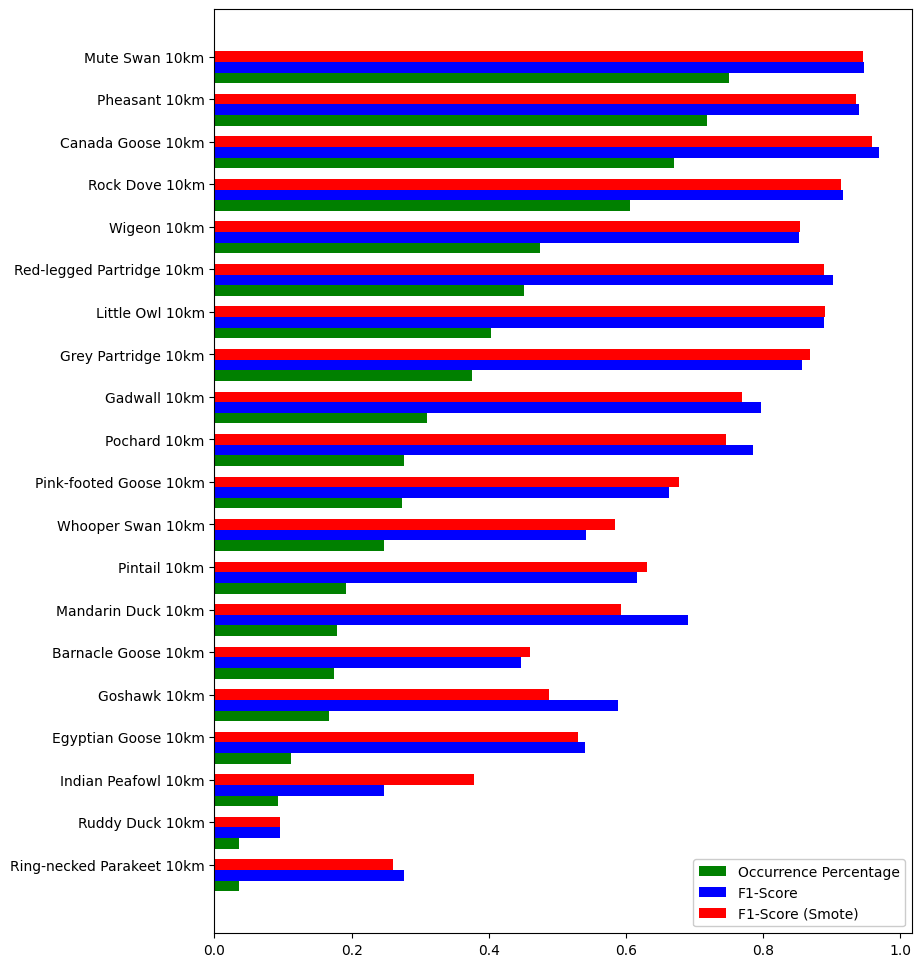

,Labels,Precision,Precision (Smote),Recall,Recall (Smote),F1,F1 (Smote),Occurrence Count,Percentage
9,Mute Swan 10km,0.948000,0.951417,0.948000,0.940000,0.948000,0.945674,2007,0.751123
10,Pheasant 10km,0.952991,0.968820,0.927235,0.904366,0.939937,0.935484,1918,0.717814
1,Canada Goose 10km,0.949580,0.954447,0.989059,0.962801,0.968917,0.958606,1789,0.669536
16,Rock Dove 10km,0.904306,0.911765,0.931034,0.916256,0.917476,0.914005,1620,0.606287
19,Wigeon 10km,0.776243,0.778393,0.946128,0.946128,0.852807,0.854103,1267,0.474177
14,Red-legged Partridge 10km,0.869822,0.853372,0.936306,0.926752,0.901840,0.888550,1208,0.452096
7,Little Owl 10km,0.859589,0.850000,0.919414,0.934066,0.888496,0.890052,1077,0.403069
5,Grey Partridge 10km,0.813187,0.824176,0.906122,0.918367,0.857143,0.868726,1002,0.375000
3,Gadwall 10km,0.780822,0.714286,0.814286,0.833333,0.797203,0.769231,830,0.310629
13,Pochard 10km,0.747573,0.734375,0.827957,0.758065,0.785714,0.746032,738,0.276198


In [13]:
# Create graphs to show off data
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [9, 12]

occurrence_count, occurrence_percentage = All_bird_occurrences['Occurrence Count'], All_bird_occurrences['Percentage']
precision = []
precision_smote = []
recall = []
recall_smote = []
f1 = []
f1_smote = []
labels = []
for dict in df_dicts:
    precision.append(dict['report']['1']['precision'])
    precision_smote.append(dict['report_smote']['1']['precision'])
    recall.append(dict['report']['1']['recall'])
    recall_smote.append(dict['report_smote']['1']['recall'])
    f1.append(dict['report']['1']['f1-score'])
    f1_smote.append(dict['report_smote']['1']['f1-score'])
    labels.append(dict['name'])



scores = pd.DataFrame({'Labels' : labels, 
                        'Precision': precision, 'Precision (Smote)': precision_smote, 
                        'Recall': recall, 'Recall (Smote)': recall_smote, 
                        'F1': f1, 'F1 (Smote)': f1_smote,
                        'Occurrence Count' : occurrence_count, 'Percentage' : occurrence_percentage} )
                        
scores.sort_values('Occurrence Count', inplace=True)

n=20
r = np.arange(n)
height = 0.25

plt.barh(r, 'Percentage', data=scores, label='Occurrence Percentage', height = height, color='g')
plt.barh(r+height, 'F1', data=scores, label='F1-Score',  height= height, color='b')
plt.barh(r+height*2, 'F1 (Smote)', data=scores, label='F1-Score (Smote)',  height = height, color='r')
plt.legend(framealpha=1, frameon=True)
plt.yticks(r+height*2, scores['Labels'])


plt.show()


scores.sort_values('Occurrence Count', ascending=False)

In [16]:
# Store dictionaries for later use
df_dicts_10km_no_fp = df_dicts
%store df_dicts_10km_no_fp

Stored 'df_dicts_10km_no_fp' (list)


In [14]:
# Export predictions to CSV for QGIS
RESULTS_PATH = 'Datasets/Machine Learning/Results/10km/'
for dict in df_dicts:
    # Join with y_test datafram
    result_df = dict['y_test'] 
    result_df['Predictions'] = dict['predictions_smote']
    display(result_df)
    result_df.to_csv(RESULTS_PATH + dict['name'] + '(without Fertiliser+Pesticides).csv')
    

,,Occurrence,Predictions
y,x,,
255000.0,235000.0,0,0
685000.0,325000.0,0,1
575000.0,435000.0,0,1
555000.0,545000.0,0,0
675000.0,245000.0,0,1
...,...,...,...
55000.0,155000.0,0,1
945000.0,215000.0,1,0
465000.0,635000.0,0,0


,,Occurrence,Predictions
y,x,,
195000.0,175000.0,0,0
445000.0,45000.0,0,0
365000.0,545000.0,1,1
345000.0,405000.0,1,1
435000.0,105000.0,0,0
...,...,...,...
65000.0,265000.0,1,1
705000.0,205000.0,1,1
295000.0,435000.0,1,1


,,Occurrence,Predictions
y,x,,
235000.0,605000.0,1,0
645000.0,695000.0,0,0
515000.0,105000.0,0,0
485000.0,95000.0,0,0
625000.0,325000.0,0,0
...,...,...,...
35000.0,25000.0,0,0
955000.0,595000.0,0,0
395000.0,455000.0,1,0


,,Occurrence,Predictions
y,x,,
215000.0,665000.0,0,0
545000.0,45000.0,0,0
445000.0,465000.0,1,1
425000.0,475000.0,1,1
535000.0,195000.0,0,0
...,...,...,...
45000.0,275000.0,1,1
875000.0,535000.0,0,0
355000.0,625000.0,0,0


,,Occurrence,Predictions
y,x,,
255000.0,525000.0,0,0
665000.0,345000.0,1,0
565000.0,365000.0,1,1
545000.0,405000.0,0,1
655000.0,555000.0,0,0
...,...,...,...
45000.0,125000.0,0,0
935000.0,675000.0,0,0
445000.0,145000.0,0,0


,,Occurrence,Predictions
y,x,,
225000.0,625000.0,1,1
545000.0,115000.0,0,0
435000.0,395000.0,1,1
415000.0,385000.0,1,1
535000.0,365000.0,1,1
...,...,...,...
55000.0,615000.0,0,0
845000.0,45000.0,0,0
355000.0,495000.0,1,1


,,Occurrence,Predictions
y,x,,
255000.0,235000.0,0,1
675000.0,45000.0,0,0
555000.0,585000.0,0,0
525000.0,175000.0,0,0
665000.0,365000.0,0,0
...,...,...,...
45000.0,175000.0,0,0
965000.0,525000.0,0,0
435000.0,545000.0,0,0


,,Occurrence,Predictions
y,x,,
205000.0,495000.0,1,1
475000.0,475000.0,1,1
385000.0,365000.0,1,1
375000.0,495000.0,1,1
465000.0,345000.0,1,1
...,...,...,...
55000.0,485000.0,0,0
835000.0,435000.0,0,0
315000.0,365000.0,1,1


,,Occurrence,Predictions
y,x,,
225000.0,365000.0,1,1
625000.0,145000.0,0,0
505000.0,185000.0,0,0
485000.0,645000.0,0,0
615000.0,225000.0,0,0
...,...,...,...
45000.0,75000.0,0,0
945000.0,685000.0,0,0
375000.0,25000.0,0,0


,,Occurrence,Predictions
y,x,,
205000.0,315000.0,1,1
465000.0,445000.0,1,1
375000.0,415000.0,1,1
355000.0,245000.0,1,1
445000.0,245000.0,0,0
...,...,...,...
75000.0,355000.0,1,0
685000.0,315000.0,1,1
305000.0,395000.0,1,1


,,Occurrence,Predictions
y,x,,
205000.0,615000.0,0,0
465000.0,465000.0,1,1
365000.0,325000.0,1,1
355000.0,545000.0,1,1
455000.0,495000.0,1,1
...,...,...,...
65000.0,215000.0,1,1
685000.0,315000.0,1,1
295000.0,265000.0,1,1


,,Occurrence,Predictions
y,x,,
305000.0,635000.0,1,1
675000.0,335000.0,1,0
565000.0,255000.0,1,1
545000.0,115000.0,0,0
665000.0,355000.0,1,1
...,...,...,...
45000.0,195000.0,0,1
925000.0,435000.0,0,0
455000.0,385000.0,1,1


,,Occurrence,Predictions
y,x,,
235000.0,405000.0,0,1
625000.0,135000.0,0,0
515000.0,375000.0,0,0
485000.0,265000.0,0,0
615000.0,295000.0,0,1
...,...,...,...
45000.0,375000.0,0,0
915000.0,235000.0,0,0
405000.0,445000.0,1,1


,,Occurrence,Predictions
y,x,,
225000.0,55000.0,0,0
595000.0,685000.0,0,0
475000.0,265000.0,0,0
455000.0,575000.0,0,0
575000.0,265000.0,0,1
...,...,...,...
45000.0,285000.0,1,0
915000.0,345000.0,0,0
365000.0,235000.0,1,0


,,Occurrence,Predictions
y,x,,
215000.0,605000.0,0,1
495000.0,415000.0,1,1
405000.0,675000.0,0,0
385000.0,535000.0,1,1
485000.0,405000.0,1,1
...,...,...,...
55000.0,75000.0,0,0
795000.0,265000.0,1,1
325000.0,575000.0,1,1


,,Occurrence,Predictions
y,x,,
245000.0,15000.0,0,0
695000.0,155000.0,0,0
575000.0,545000.0,0,0
545000.0,25000.0,0,0
685000.0,255000.0,0,0
...,...,...,...
45000.0,445000.0,0,0
975000.0,335000.0,0,0
455000.0,395000.0,0,0


,,Occurrence,Predictions
y,x,,
205000.0,375000.0,1,1
495000.0,445000.0,1,1
395000.0,505000.0,1,1
375000.0,345000.0,1,1
485000.0,425000.0,1,1
...,...,...,...
65000.0,155000.0,0,0
755000.0,125000.0,1,1
315000.0,355000.0,1,1


,,Occurrence,Predictions
y,x,,
275000.0,495000.0,0,0
695000.0,325000.0,0,0
575000.0,375000.0,0,0
555000.0,515000.0,0,0
685000.0,275000.0,0,0
...,...,...,...
35000.0,175000.0,0,0
975000.0,255000.0,0,0
455000.0,545000.0,0,0


,,Occurrence,Predictions
y,x,,
295000.0,275000.0,0,1
685000.0,55000.0,0,0
585000.0,105000.0,0,0
565000.0,205000.0,1,1
675000.0,155000.0,0,0
...,...,...,...
65000.0,245000.0,0,1
945000.0,245000.0,0,0
495000.0,575000.0,0,0


,,Occurrence,Predictions
y,x,,
235000.0,135000.0,0,0
575000.0,395000.0,1,1
475000.0,335000.0,1,1
455000.0,535000.0,0,0
565000.0,385000.0,1,1
...,...,...,...
65000.0,345000.0,0,0
845000.0,255000.0,1,1
375000.0,585000.0,0,0


In [15]:
for dict in df_dicts:
    print(dict['name'])
    display(dict['kbest']['Dataframe'])

Barnacle Goose 10km


,F Score,P Value,Attribute
25,1009.098268,3.952755e-188,Inflowing drainage direction
21,822.960158,5.383451e-158,Elevation
23,773.642924,9.675580e-150,Surface type
3,286.074265,4.806316e-61,Improve grassland
2,268.765539,1.255395e-57,Arable
22,235.656713,4.939605e-51,Cumulative catchment area
24,199.364053,1.033356e-43,Outflowing drainage direction
0,161.344102,6.172420e-36,Deciduous woodland
20,92.362595,1.602427e-21,Suburban
19,79.830321,7.431887e-19,Urban


Canada Goose 10km


,F Score,P Value,Attribute
21,7343.666630,0.000000e+00,Elevation
23,5748.855110,0.000000e+00,Surface type
25,5520.138505,0.000000e+00,Inflowing drainage direction
3,732.084357,1.082679e-142,Improve grassland
2,572.662758,7.999142e-115,Arable
24,560.712879,1.115248e-112,Outflowing drainage direction
0,324.290358,1.622397e-68,Deciduous woodland
20,180.176262,8.407061e-40,Suburban
19,50.311028,1.673556e-12,Urban
1,32.107127,1.615132e-08,Coniferous woodland


Egyptian Goose 10km


,F Score,P Value,Attribute
23,827.599456,9.132354e-159,Surface type
2,641.921266,4.265779e-127,Arable
25,641.772899,4.529104e-127,Inflowing drainage direction
21,589.698428,7.242005e-118,Elevation
20,432.216501,4.225777e-89,Suburban
24,314.637554,1.224799e-66,Outflowing drainage direction
3,305.393057,7.805663e-65,Improve grassland
0,279.121118,1.127077e-59,Deciduous woodland
19,163.844471,1.886102e-36,Urban
22,37.622328,9.858221e-10,Cumulative catchment area


Gadwall 10km


,F Score,P Value,Attribute
23,1903.437525,2.224486e-314,Surface type
25,1645.682577,9.981393e-281,Inflowing drainage direction
21,1515.568547,5.744852e-263,Elevation
2,949.689658,1.109256e-178,Arable
3,594.080640,1.201251e-118,Improve grassland
24,466.821680,1.513555e-95,Outflowing drainage direction
20,367.505198,7.557822e-77,Suburban
0,344.808292,1.734076e-72,Deciduous woodland
19,127.613146,6.120135e-29,Urban
4,42.409704,8.812937e-11,Neutral grassland


Goshawk 10km


,F Score,P Value,Attribute
23,1516.675979,4.034569e-263,Surface type
21,1440.341773,1.912231e-252,Elevation
25,1051.448282,9.009989e-195,Inflowing drainage direction
3,615.251091,2.114437e-122,Improve grassland
24,480.598054,4.304565e-98,Outflowing drainage direction
0,412.738950,1.932868e-85,Deciduous woodland
1,257.265143,2.402678e-55,Coniferous woodland
6,240.765684,4.687337e-52,Acid grassland
2,93.612918,8.702609e-22,Arable
20,47.786916,5.921305e-12,Suburban


Grey Partridge 10km


,F Score,P Value,Attribute
23,3400.634758,0.000000e+00,Surface type
21,2971.831794,0.000000e+00,Elevation
25,2704.779889,0.000000e+00,Inflowing drainage direction
2,1571.720673,1.066172e-270,Arable
3,772.281638,1.641378e-149,Improve grassland
24,584.987101,5.010287e-117,Outflowing drainage direction
0,327.534974,3.804785e-69,Deciduous woodland
20,298.002024,2.183527e-63,Suburban
19,77.634624,2.187610e-18,Urban
4,44.253781,3.486330e-11,Neutral grassland


Indian Peafowl 10km


,F Score,P Value,Attribute
23,754.797758,1.483797e-146,Surface type
25,562.392260,5.565883e-113,Inflowing drainage direction
21,554.303821,1.587591e-111,Elevation
2,494.199893,1.352579e-100,Arable
0,362.537756,6.759522e-76,Deciduous woodland
3,355.699518,1.388033e-74,Improve grassland
20,296.541227,4.222218e-63,Suburban
24,246.800525,2.918994e-53,Outflowing drainage direction
19,35.737943,2.558060e-09,Urban
22,30.997451,2.841086e-08,Cumulative catchment area


Little Owl 10km


,F Score,P Value,Attribute
23,3559.278760,0.000000e+00,Surface type
21,3136.796514,0.000000e+00,Elevation
25,3021.897153,0.000000e+00,Inflowing drainage direction
2,1533.729395,1.767848e-265,Arable
3,805.594552,4.209572e-155,Improve grassland
24,578.181222,8.231576e-116,Outflowing drainage direction
0,413.099124,1.653117e-85,Deciduous woodland
20,334.433765,1.751859e-70,Suburban
19,78.360343,1.530878e-18,Urban
4,48.334893,4.499781e-12,Neutral grassland


Mandarin Duck 10km


,F Score,P Value,Attribute
23,1570.251863,1.693384e-270,Surface type
21,1262.402052,9.104361e-227,Elevation
25,1125.652741,3.142630e-206,Inflowing drainage direction
3,719.444452,1.568797e-140,Improve grassland
0,542.531902,2.114696e-109,Deciduous woodland
2,465.257609,2.949695e-95,Arable
24,449.870098,2.130590e-92,Outflowing drainage direction
20,407.303250,2.050692e-84,Suburban
19,128.616823,3.777432e-29,Urban
5,42.361723,9.028347e-11,Calcareous grassland


Mute Swan 10km


,F Score,P Value,Attribute
21,4285.029849,0.000000e+00,Elevation
25,3424.622932,0.000000e+00,Inflowing drainage direction
23,2829.482084,0.000000e+00,Surface type
3,446.956456,7.437265e-92,Improve grassland
2,380.563329,2.424716e-79,Arable
24,322.537009,3.554675e-68,Outflowing drainage direction
0,220.990258,4.368413e-48,Deciduous woodland
20,128.128309,4.777336e-29,Suburban
19,36.403502,1.826230e-09,Urban
1,27.029498,2.155301e-07,Coniferous woodland


Pheasant 10km


,F Score,P Value,Attribute
21,3918.088889,0.000000e+00,Elevation
23,3761.808452,0.000000e+00,Surface type
25,3082.737272,0.000000e+00,Inflowing drainage direction
3,588.096290,1.397570e-117,Improve grassland
24,489.630631,9.347569e-100,Outflowing drainage direction
2,456.120338,1.464185e-93,Arable
0,242.808633,1.830101e-52,Deciduous woodland
20,133.391825,3.814028e-30,Suburban
1,35.297078,3.198252e-09,Coniferous woodland
19,31.560526,2.132963e-08,Urban


Pink-footed Goose 10km


,F Score,P Value,Attribute
25,1682.218122,1.284141e-285,Inflowing drainage direction
21,1663.088957,4.613765e-283,Elevation
23,1582.046768,4.142091e-272,Surface type
2,563.718068,3.216301e-113,Arable
24,397.048799,1.786134e-82,Outflowing drainage direction
3,354.864185,2.008795e-74,Improve grassland
0,166.093714,6.498543e-37,Deciduous woodland
20,89.444154,6.671769e-21,Suburban
17,61.599086,6.041977e-15,Littoral sediment
18,47.686527,6.226801e-12,Saltmarsh


Pintail 10km


,F Score,P Value,Attribute
25,1063.762969,1.090230e-196,Inflowing drainage direction
23,858.206427,7.999859e-164,Surface type
21,827.358145,1.001460e-158,Elevation
2,467.480402,1.142876e-95,Arable
3,323.738474,2.076614e-68,Improve grassland
24,253.487931,1.355850e-54,Outflowing drainage direction
20,181.209514,5.168309e-40,Suburban
0,144.311367,2.048534e-32,Deciduous woodland
17,112.352423,9.640675e-26,Littoral sediment
18,92.811561,1.286938e-21,Saltmarsh


Pochard 10km


,F Score,P Value,Attribute
23,1829.302778,6.722059e-305,Surface type
25,1683.265511,9.311467e-286,Inflowing drainage direction
21,1558.054709,7.942916e-269,Elevation
2,787.153513,5.158704e-152,Arable
3,562.763291,4.773860e-113,Improve grassland
24,530.095858,3.785982e-107,Outflowing drainage direction
20,412.911486,1.793393e-85,Suburban
0,317.068854,4.116031e-67,Deciduous woodland
19,152.812725,3.557010e-34,Urban
4,50.072834,1.885312e-12,Neutral grassland


Red-legged Partridge 10km


,F Score,P Value,Attribute
23,4665.558943,0.000000e+00,Surface type
21,3938.262278,0.000000e+00,Elevation
25,3326.396445,0.000000e+00,Inflowing drainage direction
2,1357.041556,1.447426e-240,Arable
3,877.316210,5.857134e-167,Improve grassland
24,800.790440,2.674164e-154,Outflowing drainage direction
0,333.873027,2.249262e-70,Deciduous woodland
20,215.130108,6.638999e-47,Suburban
5,41.288957,1.549560e-10,Calcareous grassland
22,35.695864,2.613167e-09,Cumulative catchment area


Ring-necked Parakeet 10km


,F Score,P Value,Attribute
20,423.338015,1.956491e-87,Suburban
23,263.539369,1.363343e-56,Surface type
19,223.881090,1.143620e-48,Urban
25,198.446382,1.587181e-43,Inflowing drainage direction
0,191.636187,3.852663e-42,Deciduous woodland
21,178.348178,1.989223e-39,Elevation
24,150.535710,1.051957e-33,Outflowing drainage direction
3,139.678605,1.876150e-31,Improve grassland
22,54.149221,2.460819e-13,Cumulative catchment area
2,43.990900,3.978728e-11,Arable


Rock Dove 10km


,F Score,P Value,Attribute
21,3705.998132,0.000000e+00,Elevation
23,3523.491473,0.000000e+00,Surface type
25,3167.612036,0.000000e+00,Inflowing drainage direction
3,657.131199,9.319155e-130,Improve grassland
2,574.453772,3.822481e-115,Arable
24,551.770288,4.542649e-111,Outflowing drainage direction
0,327.864746,3.283643e-69,Deciduous woodland
20,215.806810,4.847374e-47,Suburban
19,63.875294,1.953389e-15,Urban
22,26.401491,2.973417e-07,Cumulative catchment area


Ruddy Duck 10km


,F Score,P Value,Attribute
20,222.092265,2.620429e-48,Suburban
23,201.385984,4.016297e-44,Surface type
25,172.842486,2.671584e-38,Inflowing drainage direction
2,165.229518,9.785071e-37,Arable
21,161.746426,5.100030e-36,Elevation
19,132.834071,4.984261e-30,Urban
24,85.793209,3.984836e-20,Outflowing drainage direction
4,71.341242,4.862584e-17,Neutral grassland
3,66.548473,5.196588e-16,Improve grassland
0,51.792935,7.978585e-13,Deciduous woodland


Whooper Swan 10km


,F Score,P Value,Attribute
25,1078.343958,5.965819e-199,Inflowing drainage direction
21,1035.304027,3.004691e-192,Elevation
23,961.388454,1.486786e-180,Surface type
3,318.424551,2.241705e-67,Improve grassland
24,265.819805,4.812689e-57,Outflowing drainage direction
2,203.103471,1.800704e-44,Arable
0,158.129913,2.838432e-35,Deciduous woodland
20,66.652066,4.936860e-16,Suburban
9,55.135835,1.504615e-13,Heather grassland
17,48.778897,3.602661e-12,Littoral sediment


Wigeon 10km


,F Score,P Value,Attribute
25,2620.080822,0.000000e+00,Inflowing drainage direction
21,2480.090800,0.000000e+00,Elevation
23,2181.122669,0.000000e+00,Surface type
3,510.895940,1.185521e-103,Improve grassland
2,465.092494,3.165023e-95,Arable
24,411.757352,2.959990e-85,Outflowing drainage direction
0,204.705588,8.524358e-45,Deciduous woodland
20,193.263684,1.796472e-42,Suburban
19,77.447594,2.398464e-18,Urban
17,31.117309,2.672853e-08,Littoral sediment
